In [1]:
# load some extensions / magic...
%load_ext hamilton.plugins.jupyter_magic

/Users/stefankrawczyk/.pyenv/versions/knowledge_retrieval-py39/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [135]:
# import hamilton modules
from hamilton import driver
from hamilton import lifecycle

In [149]:
%%cell_to_module --help
# shows --help message

Help for %%cell_to_module magic:
  -m, --module_name: Module name to provide. Default is jupyter_module.
  -c, --config: JSON config string.
  -r, --rebuild-drivers: Flag to rebuild drivers.
  -d, --display: Flag to visualize dataflow.
  -v, --verbosity: of standard output. 0 to hide. 1 is normal, default.


Rebuilt dr with module joke, using it's config of {'dummy': 'config'}
Rebuilt dr2 with module joke, using it's config of {}
Rebuilt dr3 with module joke, using it's config of {}


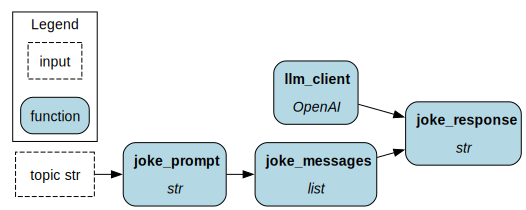

In [136]:
%%cell_to_module -m joke --display --rebuild-drivers 
# The above directive does three things: 
# 1. it creates a module with the contents of this cell
# 2. it imports the module under the name `joke`.
# 3. it displays the contents of the module.
# 4. if changes are made to the module, it will be reloaded automatically. If you constructed a driver with this module, you won't need to re-create it (in most cases).
# 5. if there is configuration passed, it will be used to help display the module.
# %%write_file joke.py
# Once you are happy with your code, you can write it to a file using the `write_file` magic command, thereby creating a module that can be imported elsewhere.
from typing import List

import openai


def llm_client() -> openai.OpenAI:
    return openai.OpenAI()


def joke_prompt(topic: str) -> str:
    return f"Tell me a short joke about {topic}"


def joke_messages(joke_prompt: str) -> List[dict]:
    return [{"role": "user", "content": joke_prompt}]


def joke_response(llm_client: openai.OpenAI,
                  joke_messages: List[dict]) -> str:
    response = llm_client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=joke_messages,
    )
    return response.choices[0].message.content

In [132]:
# create a driver --- this will be auto rebuilt (if you turn that on)
dr = (
    driver.Builder()
    .with_modules(joke)
    .with_config({"dummy": "config"})
    .build()
)

In [133]:
print(dr.execute(["joke_response"],
                 inputs={"topic": "ice cream"}))

{'joke_response': 'Why did the ice cream go to therapy?\n\nBecause it always got the scoop on everyone!'}


In [137]:
dr2 = (
    driver.Builder()
    .with_modules(joke)
    .with_adapters(lifecycle.PrintLn())  # this driver will not be rebuilt because of the adapter.
    .build()
)

In [139]:
print(dr2.execute(["joke_response"],
                 inputs={"topic": "corn chips"}))

Executing node: llm_client.
Finished debugging node: llm_client in 11.4ms. Status: Success.
Executing node: joke_prompt.
Finished debugging node: joke_prompt in 17.9μs. Status: Success.
Executing node: joke_messages.
Finished debugging node: joke_messages in 11.9μs. Status: Success.
Executing node: joke_response.
Finished debugging node: joke_response in 566ms. Status: Success.
{'joke_response': "Why don't corn chips ever fall in love?\nBecause they're too nacho-tural!"}


Rebuilt dr3 with module hello, using it's config of {}


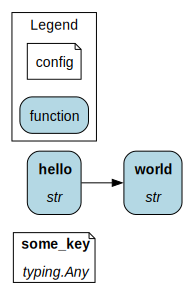

In [145]:
%%cell_to_module -m hello --display --config '{"some_key":"some_value"}' --rebuild-drivers
# shows how to pass in configuration for display
from hamilton.function_modifiers import config

def hello()->str:
    return "hi"

@config.when(some_key="some_value")
def world__1(hello: str)-> str:
    return f"{hello} world"

@config.when_not(some_key="some_value")
def world__2(hello: str)-> str:
    return f"World {hello}"

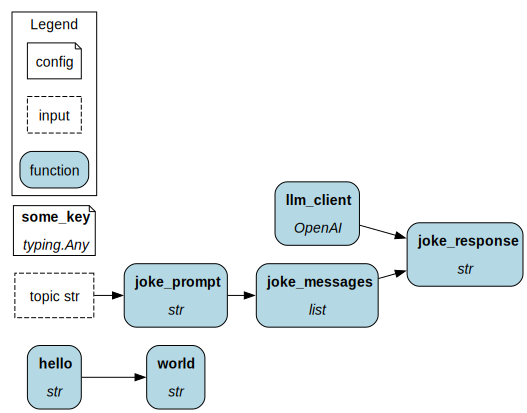

In [146]:
# shows multiple modules -- this will be rebuilt correctly if either "module" is updated if you
# turn rebuilding drivers on (`--rebuild-drivers`).
dr3 = (
        driver.Builder()
        .with_modules(joke, hello)
        .with_config({"some_key": "some_value"})
        .build()
    )
dr3.display_all_functions()

In [147]:
dr3.execute(["world"], inputs={})

{'world': 'hi world'}